\

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FER/

/content/drive/MyDrive/FER


In [ ]:
!ls

checkpoint  fer2013  fer2013.tar.gz  model_plot.png


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 1, 2, 3, 6, 4, 5])

In [ ]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

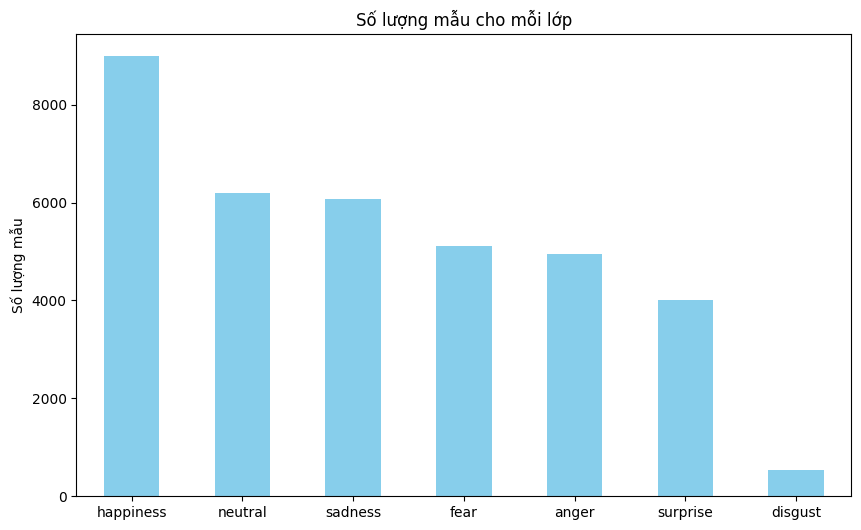

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đếm số lượng mẫu cho mỗi lớp
class_counts = df['emotion'].map({0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}).value_counts()


# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng mẫu cho mỗi lớp')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=0)
plt.show()


In [ ]:
np.array(df.pixels.loc[0].split(' ')).reshape(48,48)

array([['127', '121', '124', ..., '254', '250', '255'],
       ['143', '115', '115', ..., '248', '251', '247'],
       ['139', '152', '109', ..., '240', '245', '246'],
       ...,
       ['32', '22', '12', ..., '66', '106', '214'],
       ['11', '2', '6', ..., '56', '108', '225'],
       ['45', '7', '15', ..., '53', '118', '233']], dtype='<U3')

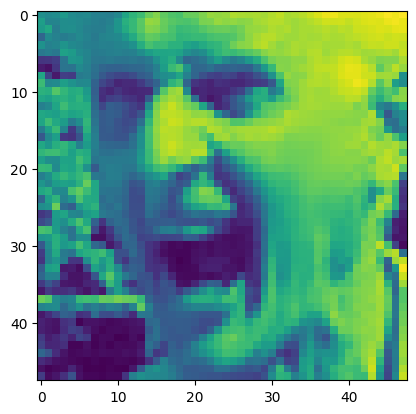

In [ ]:
pyplot.imshow(np.array(df.pixels.loc[0].split(' ')).reshape(48,48).astype('float'))

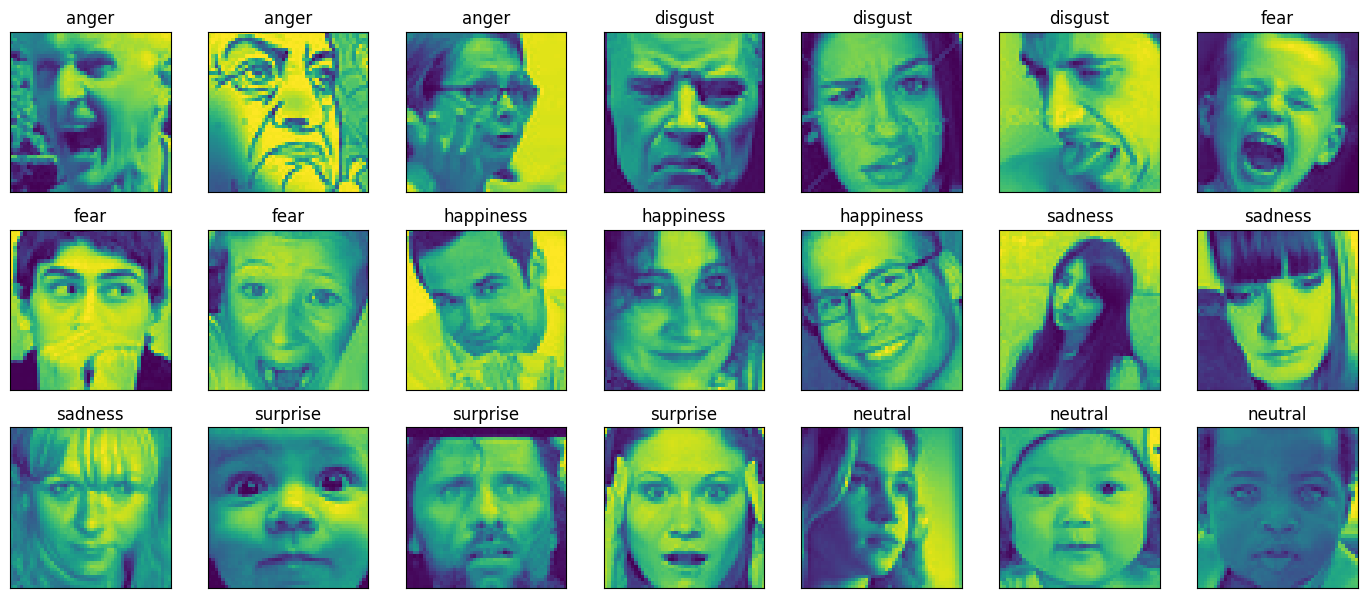

In [ ]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [ ]:
#img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float'))
# Lọc DataFrame chỉ để lại các hàng có 'Usage' là 'Training'
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PrivateTest']

# Áp dụng quy trình xử lý cho cột 'pixels' của DataFrame lọc
train_array = train_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float'))
val_array = val_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float'))

In [ ]:
test_df = df[df['Usage'] == 'PublicTest']
test_array = test_df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float'))

In [ ]:
train_array.shape

(56000,)

In [ ]:
val_array.shape

(3410,)

In [ ]:
train_array = np.stack(train_array, axis=0)
val_array = np.stack(val_array, axis=0)

In [ ]:
test_array = np.stack(test_array, axis=0)

In [ ]:
train_array.shape
val_array.shape

(3410, 48, 48, 1)

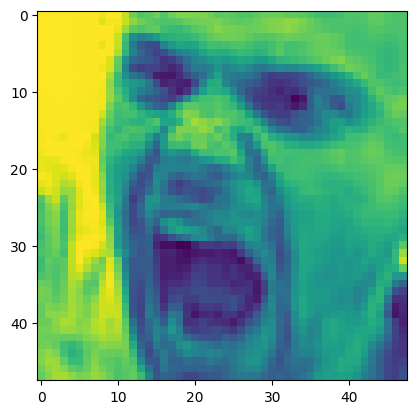

In [ ]:
pyplot.imshow(train_array[1])

In [ ]:
lables = df.emotion.values

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(img_array,lables,test_size = .1)
# Lấy ra dữ liệu huấn luyện từ img_array
X_train = np.stack(train_array)  # Chuyển đổi Series thành mảng numpy

# Lấy ra nhãn tương ứng từ cột 'emotion'
y_train = train_df.emotion.values

X_val = np.stack(val_array)  # Chuyển đổi Series thành mảng numpy

# Lấy ra nhãn tương ứng từ cột 'emotion'
y_val = val_df.emotion.values

In [ ]:
X_test = np.stack(test_array)
y_test = test_df.emotion.values

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((56000, 48, 48, 1), (3410, 48, 48, 1), (56000,), (3410,))

In [ ]:
X_train = X_train/255
X_val = X_val/255

In [ ]:
X_test = X_test/255

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
no_of_classes = 7

basemodel = Sequential()

#1st CNN layer
basemodel.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
basemodel.add(BatchNormalization())
basemodel.add(Activation('relu'))
basemodel.add(MaxPooling2D(pool_size = (2,2)))
basemodel.add(Dropout(0.25))

#2nd CNN layer
basemodel.add(Conv2D(128,(3,3),padding = 'same'))
basemodel.add(BatchNormalization())
basemodel.add(Activation('relu'))
basemodel.add(MaxPooling2D(pool_size = (2,2)))
basemodel.add(Dropout (0.25))

#3rd CNN layer
basemodel.add(Conv2D(256,(3,3),padding = 'same'))
basemodel.add(BatchNormalization())
basemodel.add(Activation('relu'))
basemodel.add(MaxPooling2D(pool_size = (2,2)))
basemodel.add(Dropout (0.25))

#4th CNN layer
basemodel.add(Conv2D(512,(3,3), padding='same'))
basemodel.add(BatchNormalization())
basemodel.add(Activation('relu'))
basemodel.add(MaxPooling2D(pool_size=(2, 2)))
basemodel.add(Dropout(0.25))


basemodel.add(Flatten())

#Fully connected 1st layer
basemodel.add(Dense(256))
basemodel.add(BatchNormalization())
basemodel.add(Activation('relu'))
basemodel.add(Dropout(0.5))


# Fully connected layer 2nd layer
basemodel.add(Dense(512))
basemodel.add(BatchNormalization())
basemodel.add(Activation('relu'))
basemodel.add(Dropout(0.5))

basemodel.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
basemodel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_31 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_19 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
basemodel.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = .0001),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [ ]:
file_name = 'final_model.h5'
checkpoint_path = os.path.join('checkpoint', file_name)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

# Định nghĩa callback cho Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Định nghĩa callback cho Reduce Learning Rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Giảm tỷ lệ học xuống 20% khi kích hoạt
    patience=3,  # Số epoch không cải thiện trước khi giảm tỷ lệ học
    verbose=1,  # In thông báo khi giảm tỷ lệ học
    min_lr=1e-6  # Giới hạn tỷ lệ học tối thiểu
)

# Tạo danh sách các callbacks
callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [ ]:
history = basemodel.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
1750/1750 [==============================] - ETA: 0s - loss: 2.1646 - accuracy: 0.2226
Epoch 1: val_accuracy did not improve from 0.68270
1750/1750 [==============================] - 31s 16ms/step - loss: 2.1646 - accuracy: 0.2226 - val_loss: 1.8749 - val_accuracy: 0.2384 - lr: 1.0000e-04
Epoch 2/50
1747/1750 [============================>.] - ETA: 0s - loss: 1.7801 - accuracy: 0.3390
Epoch 2: val_accuracy did not improve from 0.68270
1750/1750 [==============================] - 27s 16ms/step - loss: 1.7799 - accuracy: 0.3390 - val_loss: 1.9034 - val_accuracy: 0.2798 - lr: 1.0000e-04
Epoch 3/50
1747/1750 [============================>.] - ETA: 0s - loss: 1.5481 - accuracy: 0.4197
Epoch 3: val_accuracy did not improve from 0.68270
1750/1750 [==============================] - 28s 16ms/step - loss: 1.5480 - accuracy: 0.4198 - val_loss: 1.4838 - val_accuracy: 0.4323 - lr: 1.0000e-04
Epoch 4/50
1750/1750 [==============================] - ETA: 0s - loss: 1.4209 - accuracy: 0.4632

In [ ]:
X_train.shape

In [ ]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time
for k in range(40):
  print(f'actual label is {label_to_text[y_val[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(X_val[k],0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot.imshow(X_val[k].reshape((48,48)))
  pyplot.show()
  time.sleep(3)
  clear_output(wait=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model

In [ ]:
class_counts = np.bincount(y_test)

# In số lượng của từng lớp
for class_idx, count in enumerate(class_counts):
    print(f'Class {class_idx}: {count} samples')

107/107 [==============================] - 1s 5ms/step


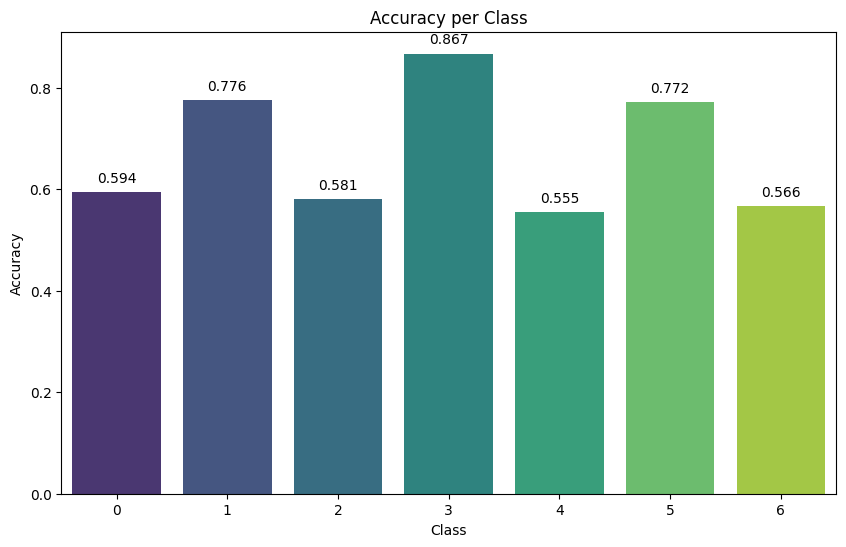

In [ ]:
file_name = 'final_model.h5'
checkpoint_path = os.path.join('checkpoint', file_name)  # Đặt đúng đường dẫn của mô hình
loaded_model = load_model(checkpoint_path)

# Kiểm tra mô hình trên tập dữ liệu kiểm tra
y_pred = loaded_model.predict(X_test)
y_pred_labels = [np.argmax(i) for i in y_pred]
y_true_labels = np.array(y_test)

# In báo cáo phân loại
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Trích xuất độ chính xác cho từng lớp
class_accuracy_data = {
    'Class': [int(label) for label in report.keys() if label.isdigit()],
    'Accuracy': [round(report[label]['precision'], 3) for label in report.keys() if label.isdigit()]
}

# Tạo DataFrame từ dữ liệu
class_accuracy_df = pd.DataFrame(class_accuracy_data)

# Vẽ biểu đồ độ chính xác cho từng lớp
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class', y='Accuracy', data=class_accuracy_df, palette='viridis')

# Hiển thị giá trị cụ thể trên từng thanh
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.show()

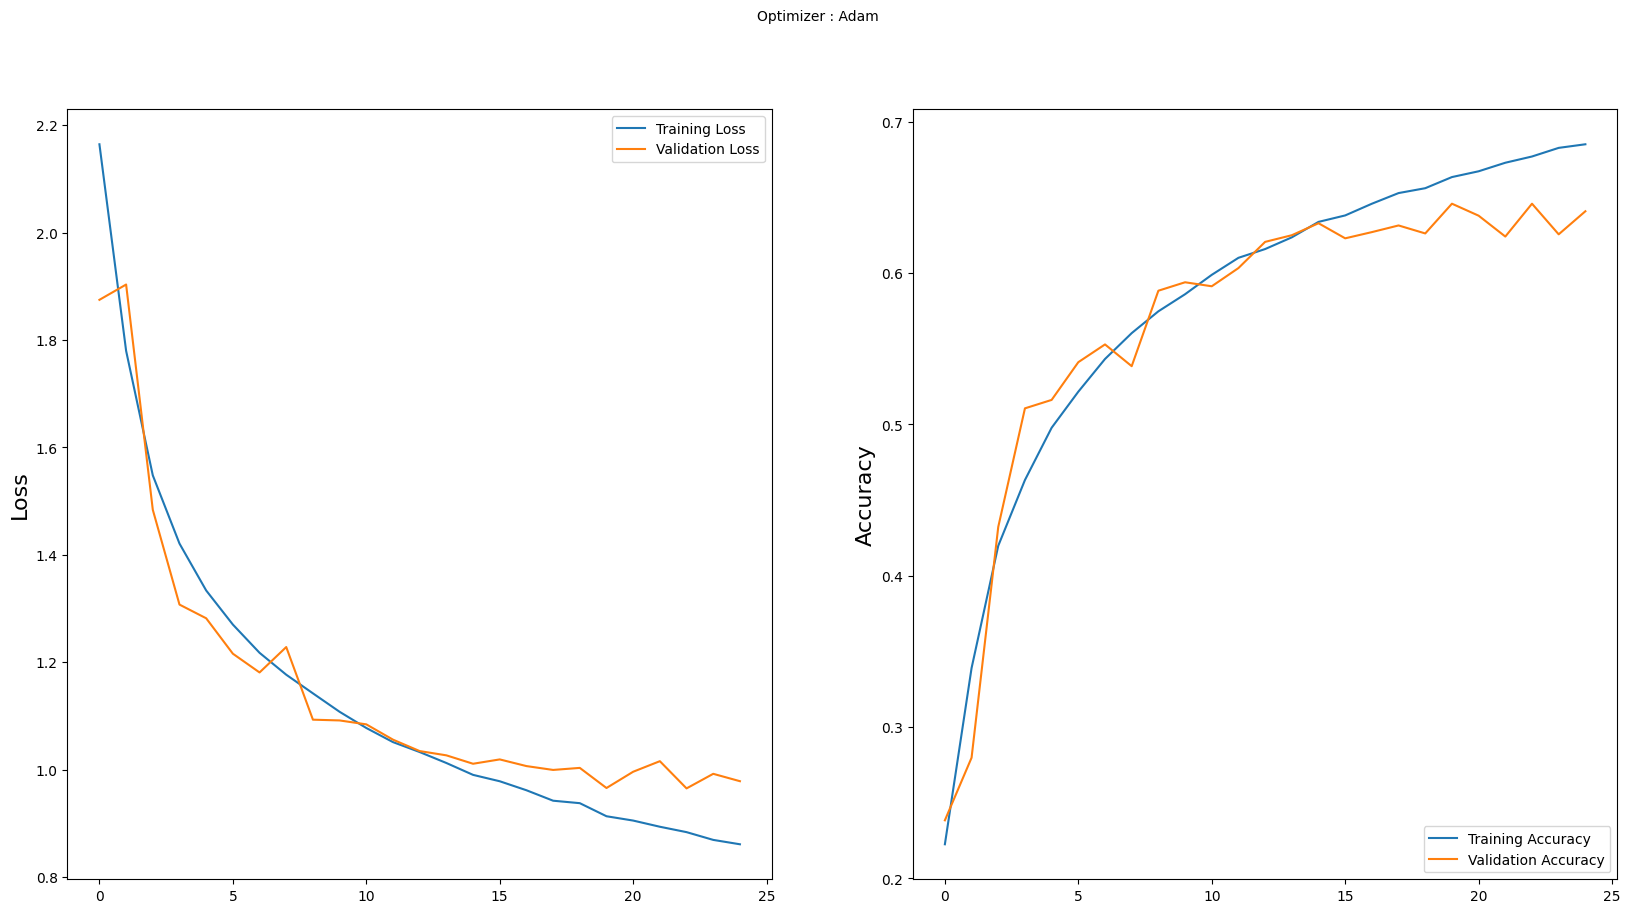

In [ ]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd


# Đọc và tải mô hình
model2 = load_model(os.path.join('checkpoint', 'sample5layer_model.h5'))  # Thay đổi tên file và đường dẫn nếu cần
model1 = load_model(os.path.join('checkpoint', 'balanced_model.h5'))
model3 = load_model(os.path.join('checkpoint', '5x1_model.h5'))
model4 = load_model(os.path.join('checkpoint', 'vgg16_balanced_model.h5'))

# Dự đoán nhãn sử dụng mô hình
y_prob1 = model1.predict(X_test)
y_pred1 = np.argmax(y_prob1, axis=1)

y_prob2 = model2.predict(X_test)
y_pred2 = np.argmax(y_prob2, axis=1)

y_prob3 = model3.predict(X_test)
y_pred3 = np.argmax(y_prob3, axis=1)

y_prob4 = model4.predict(X_test)
y_pred4 = np.argmax(y_prob4, axis=1)

# Tính toán Accuracy, Precision và Recall
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1, average='weighted')  # Chọn average phù hợp
recall1 = recall_score(y_test, y_pred1, average='weighted')

accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2, average='weighted')
recall2 = recall_score(y_test, y_pred2, average='weighted')

accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3, average='weighted')
recall3 = recall_score(y_test, y_pred3, average='weighted')

accuracy4 = accuracy_score(y_test, y_pred4)
precision4 = precision_score(y_test, y_pred4, average='weighted')
recall4 = recall_score(y_test, y_pred4, average='weighted')

accuracy1 = round(accuracy1*100, 2)
precision1 = round(precision1*100, 2)
recall1 = round(recall1*100, 2)

accuracy2 = round(accuracy2*100, 2)
precision2 = round(precision2*100, 2)
recall2 = round(recall2*100, 2)

accuracy3 = round(accuracy3*100, 2)
precision3 = round(precision3*100, 2)
recall3 = round(recall3*100, 2)

accuracy4 = round(accuracy4*100, 2)
precision4 = round(precision4*100, 2)
recall4 = round(recall4*100, 2)


# Tạo DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    '4 layer': [accuracy1, precision1, recall1],
    '''5 layer
    (128-1024x2)''': [accuracy2, precision2, recall2],
    '''5 layer
    (64-1024)''': [accuracy3, precision3, recall3],
    'VGG16': [accuracy4, precision4, recall4],
}



df = pd.DataFrame(data)


# In bảng
print(df)

# Vẽ bảng
# Ghi chú: Để vẽ bảng, bạn có thể sử dụng thư viện matplotlib hoặc seaborn
# Ví dụ sử dụng matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')

# Sử dụng bbox để làm cho bảng vừa khít với khung
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(8)  # Điều chỉnh kích thước chữ của bảng

plt.show()